# Predykcja churn'u z wykorzystaniem uczenia maszynowego / Machine learning for churn prediction

## Introduction

In the ever-evolving banking landscape, maintaining customer loyalty is crucial. **Customer churn**, often referred to as *customer attrition*, describes a situation in which a customer ceases to use services within a certain timeframe. This occurrence significantly influences profitability, particularly in industries such as banking, where revenues are largely based on customer loyalty and subscription models. The cost of acquiring a new customer can be up to five times more than retaining an existing one, making the analysis of customer churn an indispensable component of strategic business decisions.

The objective of this project is to delve into the fascinating area of customer churn in the banking sector. This exploration will commence with an *exploratory data analysis* (EDA) to identify and visualize the main factors contributing to customer churn. This knowledge will subsequently aid in the development of machine learning models capable of predicting whether a customer is likely to churn or not.

The task at hand is fundamentally a classification problem, and in this context, optimizing for the **F1 score** is a strategic choice. The F1 score is the harmonic mean of precision and recall. Balancing these two metrics can often result in a better model for certain business contexts. By optimizing for the F1 score, the bank can seek to balance these two objectives. This balance could lead to more effective identification of customers who might leave, allowing the bank to take preemptive action and potentially resulting in better customer retention and a more satisfying customer experience.

Now, let's embark on this journey


### Dataset overview

Dataset is coming from Kaggle (can be find under this link:https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)<br/>
<br/>Features description:
1. **customer_id**: Unique identifier for each individual client.
2. **credit_score**: Numerical representation of the client's credit risk, based on their credit history.
3. **country**: Client's country of residence.
4. **gender**: Biological sex of the client.
5. **age**: Client's age in years.
6. **tenure**: Length of the client's relationship with the bank, measured in years.
7. **balance**: Current balance in the client's bank account.
8. **products_number**: Quantity of banking products the client is using.
9. **credit_card**: Binary indication of whether the client has a credit card issued by the bank.
10. **active_member**: Binary indication of the client's activity status with the bank.
11. **estimated_salary**: Estimated annual income of the client.
12. **churn**: Binary target variable indicating whether the client discontinued their relationship with the bank.
 This is the **target** variable

## Import Libraries

In [1]:
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, classification_report, precision_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb
import scipy.stats as ss
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.decomposition import PCA

In [2]:
from support_functions import *

## Loading dataset

In [3]:
df_full = pd.read_csv('./Bank_Customer_Churn_Prediction.csv')

Before proceeding with the analysis, the dataset will be split into a **training set** and a **test set**. This step is crucial to prevent data leakage and ensure that the model's evaluation is based on unseen data, providing a more accurate measure of its predictive performance. In this case, a test set size of 20% will be used.

## Splitting dataset into train and test

In [4]:
df_train, df_test = train_test_split(df_full,
                                     test_size=0.2, 
                                     stratify=df_full['churn'], 
                                     random_state=0)

## Base information about dataset

In [5]:
df_train.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
493,15725679,531,France,Female,47,6,0.00,1,0,0,194998.34,1
6839,15768282,724,Germany,Male,36,6,94615.11,2,1,1,10627.21,0
170,15587562,484,France,Female,29,4,130114.39,1,1,0,164017.89,0
4958,15594502,655,France,Male,37,6,109093.41,2,1,0,1775.52,0
4271,15707132,465,France,Male,33,5,0.00,2,0,1,78698.09,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 493 to 8389
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       8000 non-null   int64  
 1   credit_score      8000 non-null   int64  
 2   country           8000 non-null   object 
 3   gender            8000 non-null   object 
 4   age               8000 non-null   int64  
 5   tenure            8000 non-null   int64  
 6   balance           8000 non-null   float64
 7   products_number   8000 non-null   int64  
 8   credit_card       8000 non-null   int64  
 9   active_member     8000 non-null   int64  
 10  estimated_salary  8000 non-null   float64
 11  churn             8000 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 812.5+ KB


There are no **null** values in data set so there is no need for any additional step to fill in missing data

In [7]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,8000.0,1.569100e+07,71915.178542,15565701.00,1.562885e+07,1.569149e+07,1.575341e+07,15815690.00
credit_score,8000.0,6.506830e+02,96.507674,350.00,5.840000e+02,6.520000e+02,7.180000e+02,850.00
age,8000.0,3.885863e+01,10.440175,18.00,3.200000e+01,3.700000e+01,4.400000e+01,92.00
tenure,8000.0,4.978625e+00,2.886210,0.00,2.000000e+00,5.000000e+00,7.000000e+00,10.00
balance,8000.0,7.684780e+04,62253.337409,0.00,0.000000e+00,9.746699e+04,1.278426e+05,250898.09
products_number,8000.0,1.526000e+00,0.582552,1.00,1.000000e+00,1.000000e+00,2.000000e+00,4.00
credit_card,8000.0,7.060000e-01,0.455620,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
active_member,8000.0,5.188750e-01,0.499675,0.00,0.000000e+00,1.000000e+00,1.000000e+00,1.00
estimated_salary,8000.0,1.003584e+05,57676.075102,11.58,5.101484e+04,1.006084e+05,1.495529e+05,199992.48
churn,8000.0,2.037500e-01,0.402810,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.00


In [8]:
df_train.nunique()

customer_id         8000
credit_score         455
country                3
gender                 2
age                   68
tenure                11
balance             5134
products_number        4
credit_card            2
active_member          2
estimated_salary    7999
churn                  2
dtype: int64



**Conclusions:**

1. Feature **customer_id** is individual for each customer and therefore does not carry any analytical value, so it can be excluded from further analysis.

2. After examining the statistics of numerical features in the dataset, it is evident that there are no extreme or obviously incorrect values, with one exception. The **estimated_salary** feature has a very low minimum value. However, all other data points fall within reasonable and expected ranges, indicating good data quality.

These observations provide confidence in the reliability and integrity of the dataset, allowing for meaningful analysis and modeling.


## Exploratory Data Analysis

### Target variable: Churn
Churn is target variable for this analysis which takes two values 
<br/> 0 - customer did not churn 
<br/> 1 - customer churned

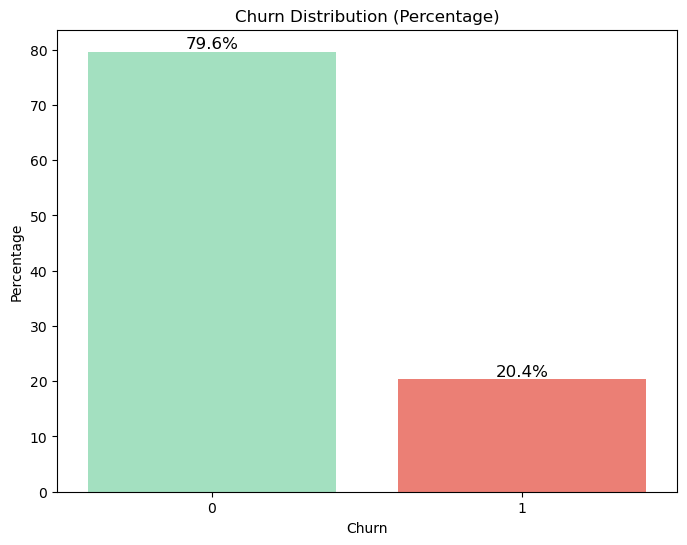

In [9]:
#Churn and retain % barplot
churn_counts = df_train['churn'].value_counts(normalize=True)
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=churn_counts.index, y=churn_counts.values * 100, palette={0: '#99eabf', 1: '#FF6F61'})
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom', fontsize=12)

plt.xlabel('Churn')
plt.ylabel('Percentage')
plt.title('Churn Distribution (Percentage)')
plt.show()

According to the analysis presented in the chart above, the dataset exhibits an imbalance in the target variable, with approximately 20% of customers labeled as churned (churn=1), while the remaining 80% are classified as non-churned (churn=0). This considerable difference in class distribution indicates an imbalanced dataset.

In [10]:
df_train

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
493,15725679,531,France,Female,47,6,0.00,1,0,0,194998.34,1
6839,15768282,724,Germany,Male,36,6,94615.11,2,1,1,10627.21,0
170,15587562,484,France,Female,29,4,130114.39,1,1,0,164017.89,0
4958,15594502,655,France,Male,37,6,109093.41,2,1,0,1775.52,0
4271,15707132,465,France,Male,33,5,0.00,2,0,1,78698.09,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6727,15610416,745,France,Female,36,9,0.00,1,1,0,19605.18,1
4674,15689492,850,Germany,Male,41,1,176958.46,2,0,1,125806.30,0
6399,15738501,601,Germany,Male,48,9,163630.76,1,0,1,41816.49,1
872,15794549,722,France,Female,35,2,163943.89,2,1,1,15068.18,0


### Credit Score

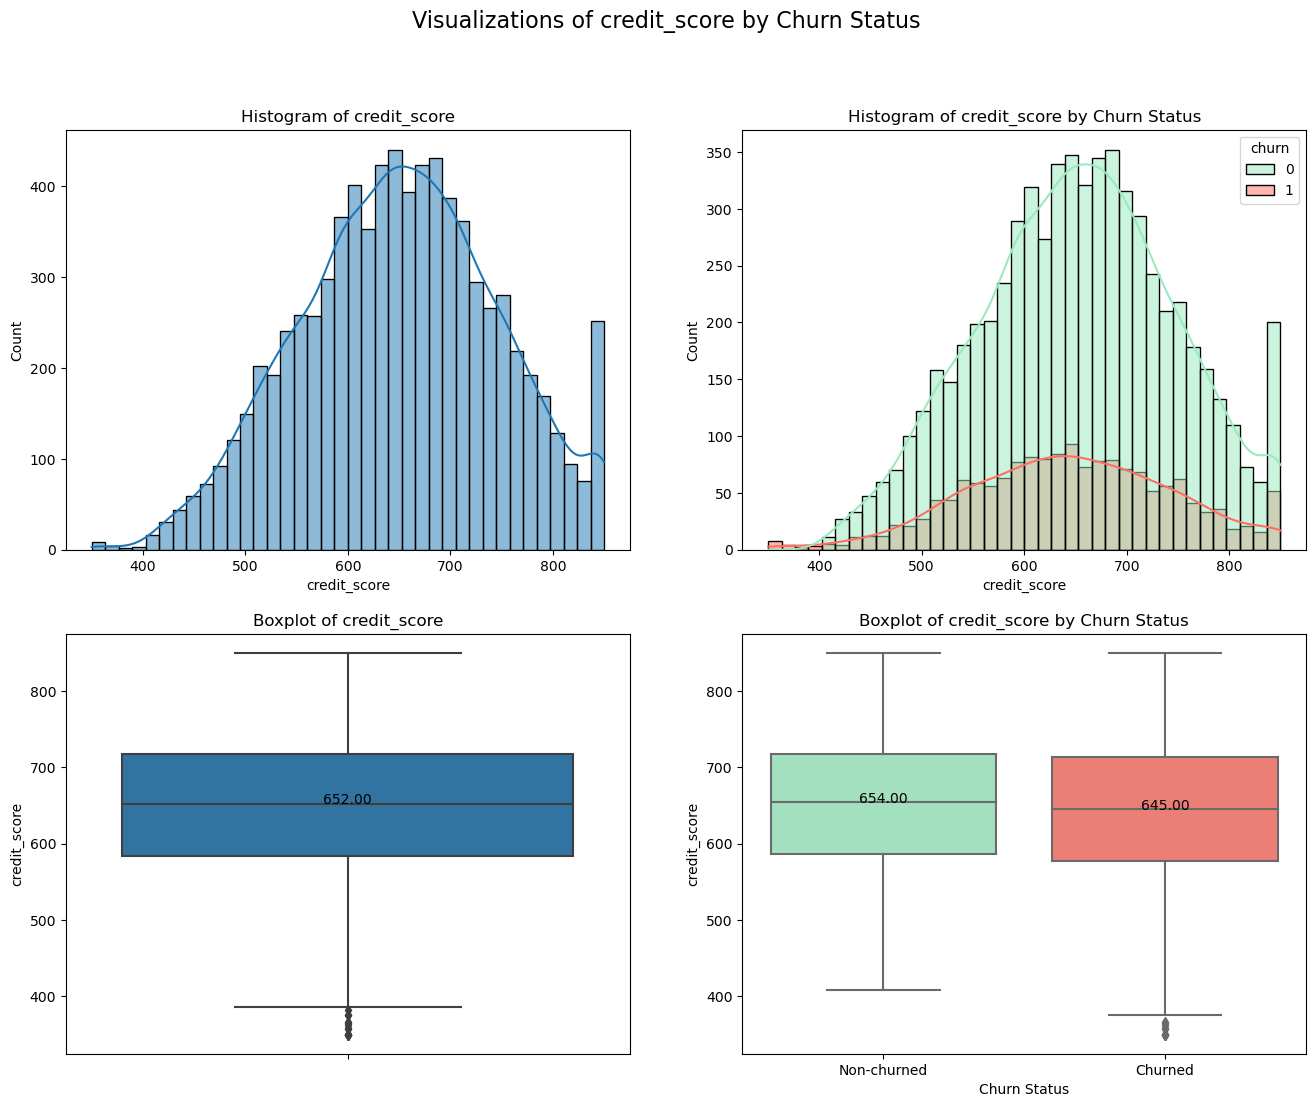

In [11]:
plot_numerical_feature('credit_score', data=df_train)

**Conclusions:**
1. The distribution of the credit score feature appears to be approximately normally distributed, with a large number of observations in the last bin indicating higher credit scores.
2. When comparing churned and non-churned customers, there is no significant difference in their credit scores. However, the distribution of credit scores for churned customers exhibits a slightly longer left tail and a slightly lower median compared to non-churned customers.

In [12]:
#check if is there any diffrerence in churn distribution for max credit score
df_train[df_train['credit_score'] == 850]['churn'].mean()

0.2

### Country

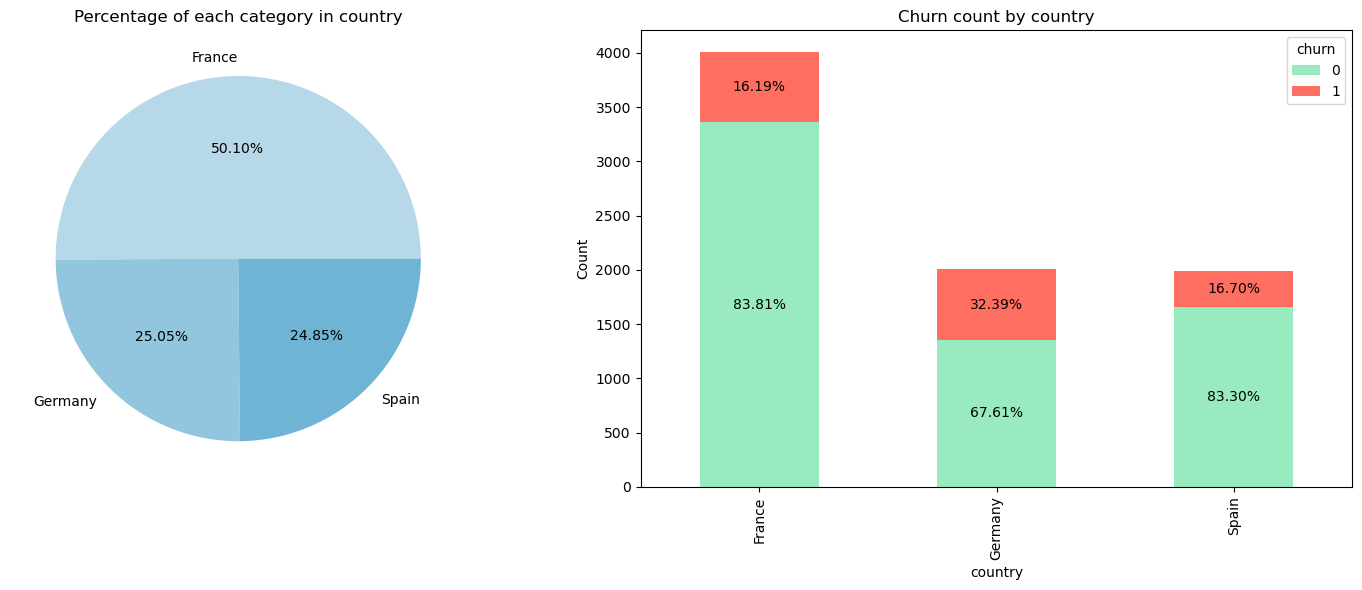

In [13]:
plot_categorical_feature('country', data=df_train)

**Conclusions:**

1. The distribution of clients across countries shows that the majority of clients (50%) are from France, while Germany and Spain contribute nearly equal proportions, each accounting for approximately 25% of the clients.

2. Examining the churn ratios reveals interesting insights. The churn rate for both France and Spain stands at around 16%, indicating a relatively similar likelihood of customer attrition in these countries. However, a notable disparity is observed in Germany, where the churn rate reaches approximately 32%. This signifies a significantly higher churn rate in Germany compared to the other two countries.





### Gender

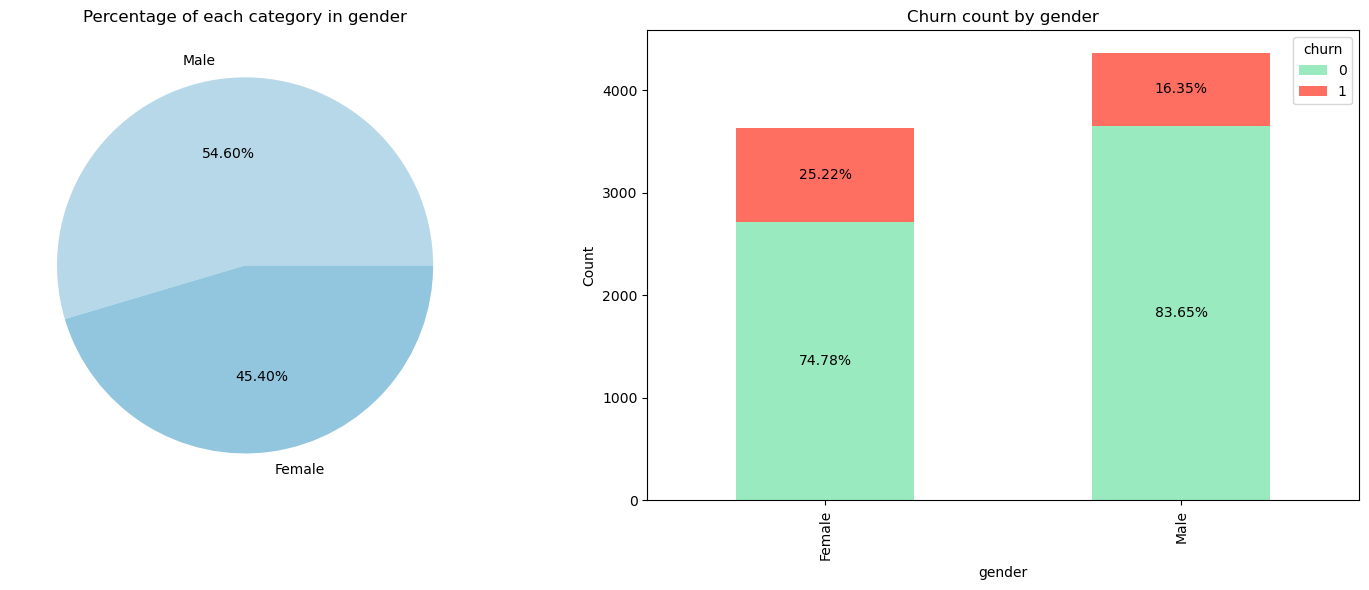

In [14]:
plot_categorical_feature('gender', data=df_train)

Conclusions:

1. The gender distribution among bank customers reveals that approximately 55% of the customers are men, while women constitute around 45% of the customer base.

2. The churn rate for female customers stands at approximately 25%, indicating a relatively higher likelihood of churn among female customers. In contrast, the churn rate for male customers is around 16%.



### Age

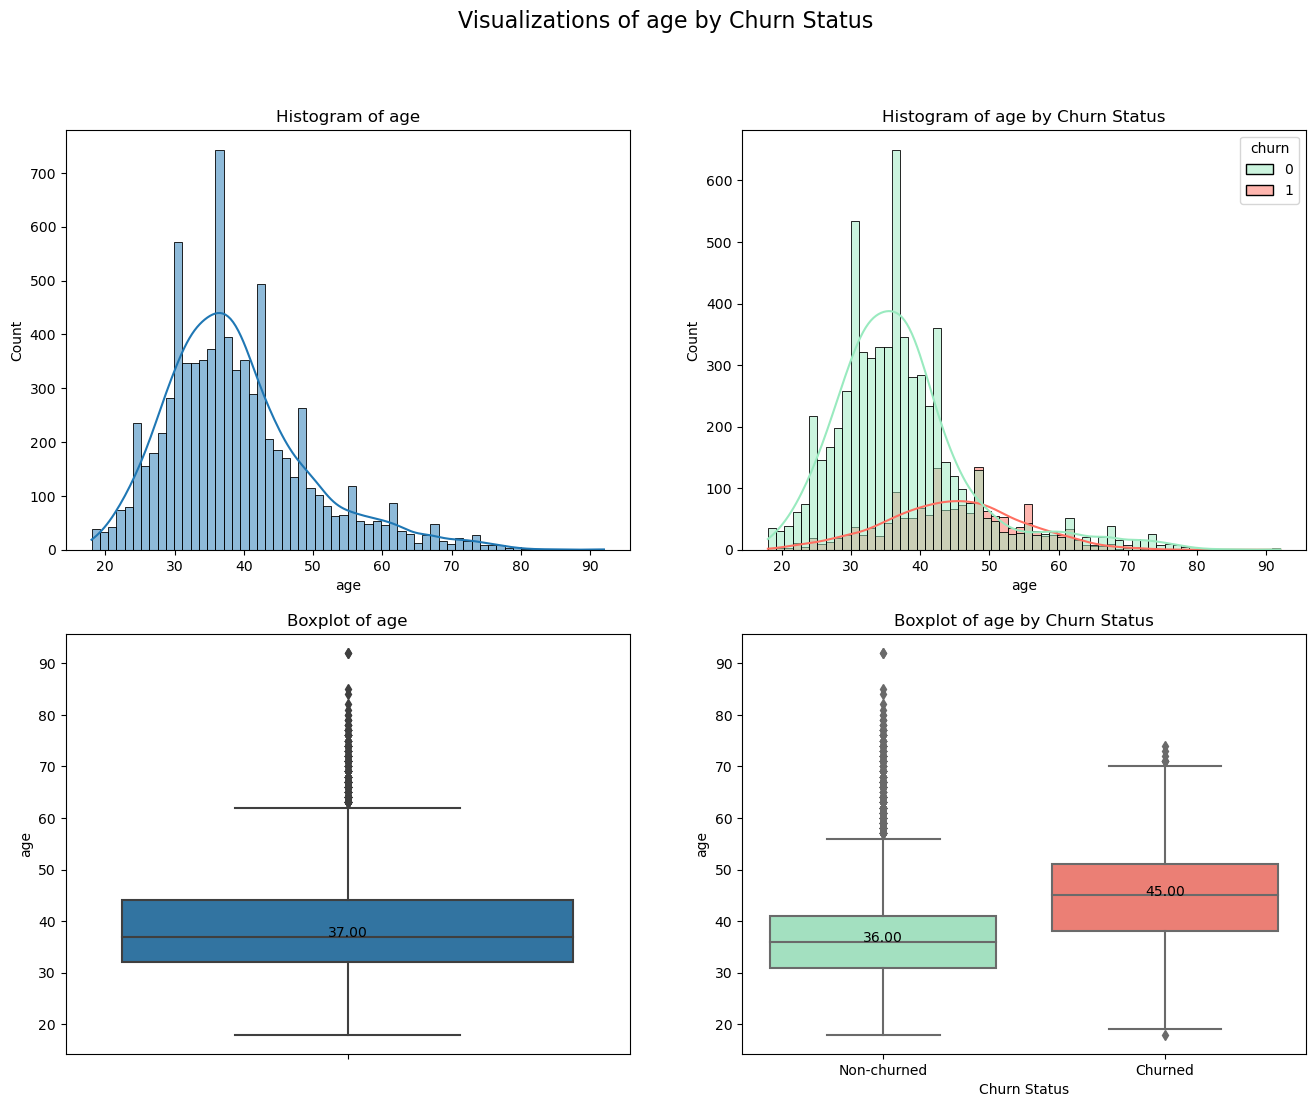

In [15]:
plot_numerical_feature('age', data=df_train)

**Conclusions:**

1. The distribution of the age feature reveals a positive skewness, indicating that the majority of bank customers fall within a relatively younger age group. However, there is a noticeable difference in the age distribution between churned and non-churned customers. The median age of churned customers is significantly higher (45) compared to non-churned customers (36), particularly within the age group of 40 to 65.

2. Examining the churn rate within the age group of 40 to 65 reveals a higher churn rate of approximately 40%. This churn rate is approximately two times higher than the overall churn rate observed in the entire dataset.

3. To gain a deeper understanding, it may be beneficial to explore the age distribution in relation to generational cohorts. Binning the age feature based on generations, such as Boomers, Generation X, Millennials, and Generation Z, can help identify any generational differences in churn behavior.

In [16]:
#Checking % churn between age 40 and 65
filtered_data = df_train[(df_train['age'] > 40) & (df_train['age'] < 65)]
round(filtered_data['churn'].mean(),3)

0.403

Generation bins obtain from: https://www.pewresearch.org/short-reads/2019/01/17/where-millennials-end-and-generation-z-begins/

In [17]:
def bin_age_by_generation(df, column='age'):
    df = df.copy()
    
    bins = [0, 26, 42, 58, 77, 98]
    labels = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers', 'Silent Generation']
    df['generation'] = pd.cut(df[column], bins, labels=labels, right=False, include_lowest=True)
    return df


df_exp = bin_age_by_generation(df_train)

In [18]:
df_exp.groupby('generation')['churn'].mean()

generation
Gen Z                0.083832
Millennials          0.111404
Gen X                0.428014
Baby Boomers         0.328571
Silent Generation    0.000000
Name: churn, dtype: float64

There are significant differences among generation in terms of churn rate

### Tenure

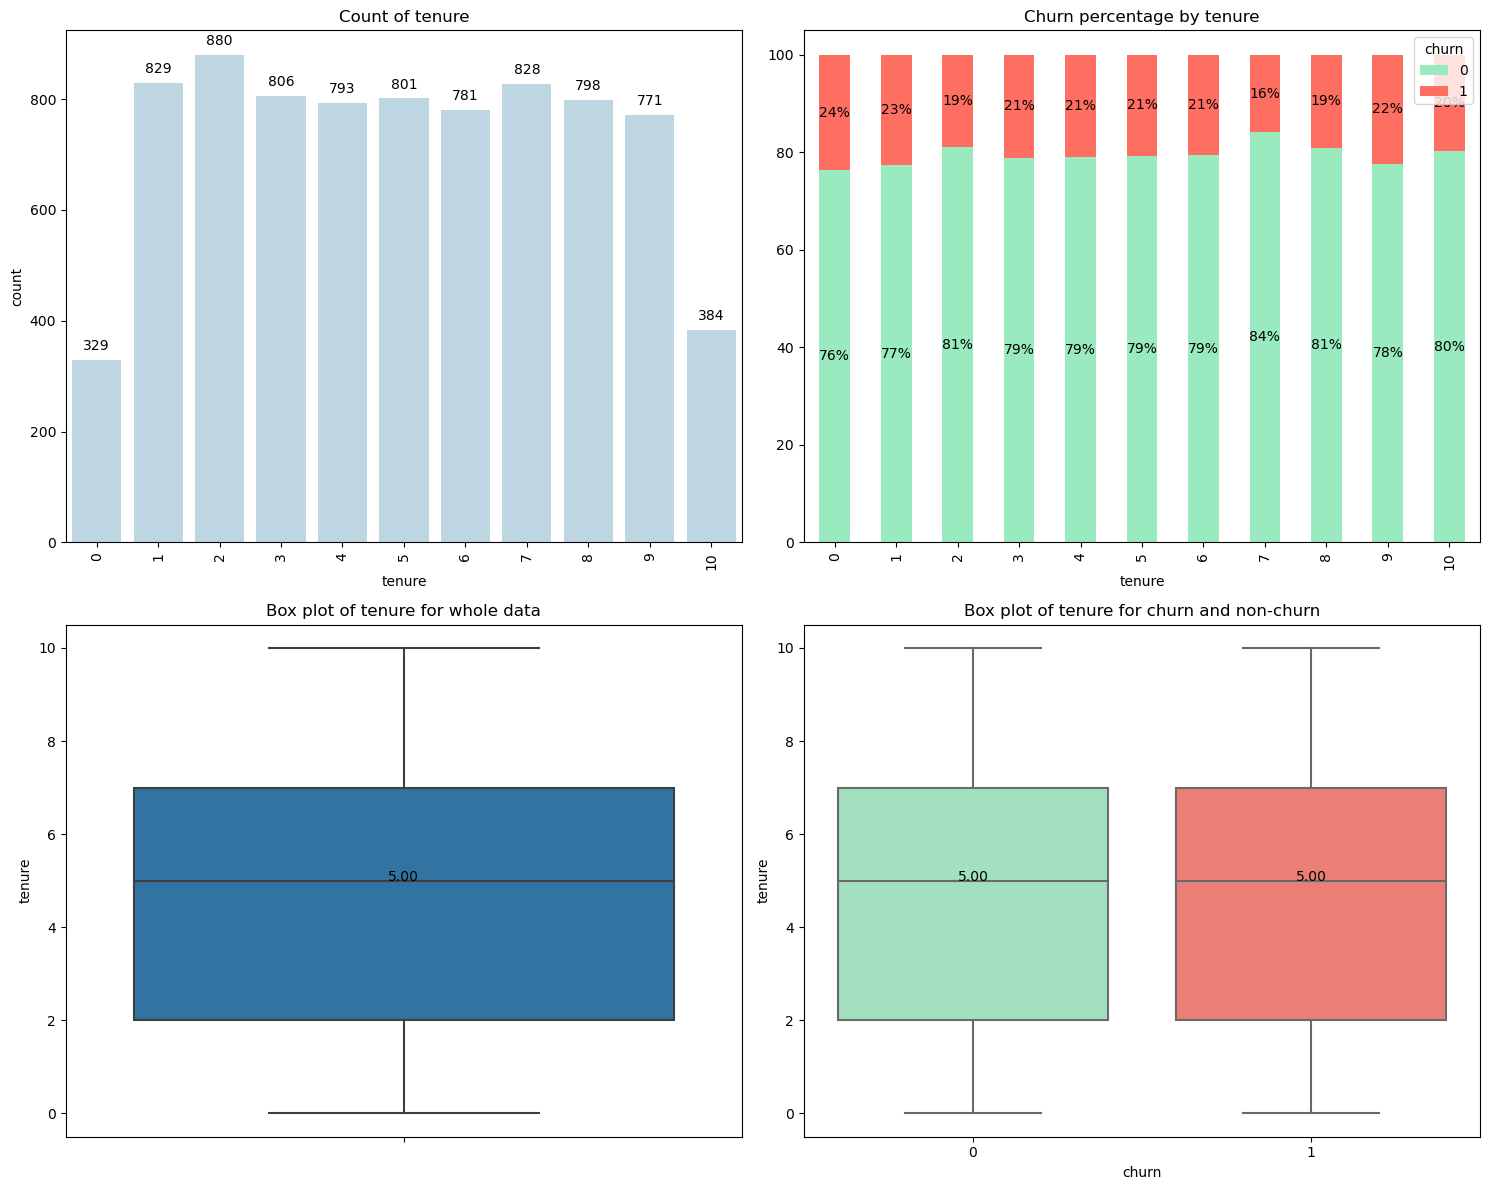

In [19]:
plot_ordinal_feature('tenure', data=df_train)

**Conclusions:**
1. The duration of years (tenure) does not seem to have a significant impact on the churn rate. There is no apparent pattern or trend in the churn rate across different tenure periods.

### Balance

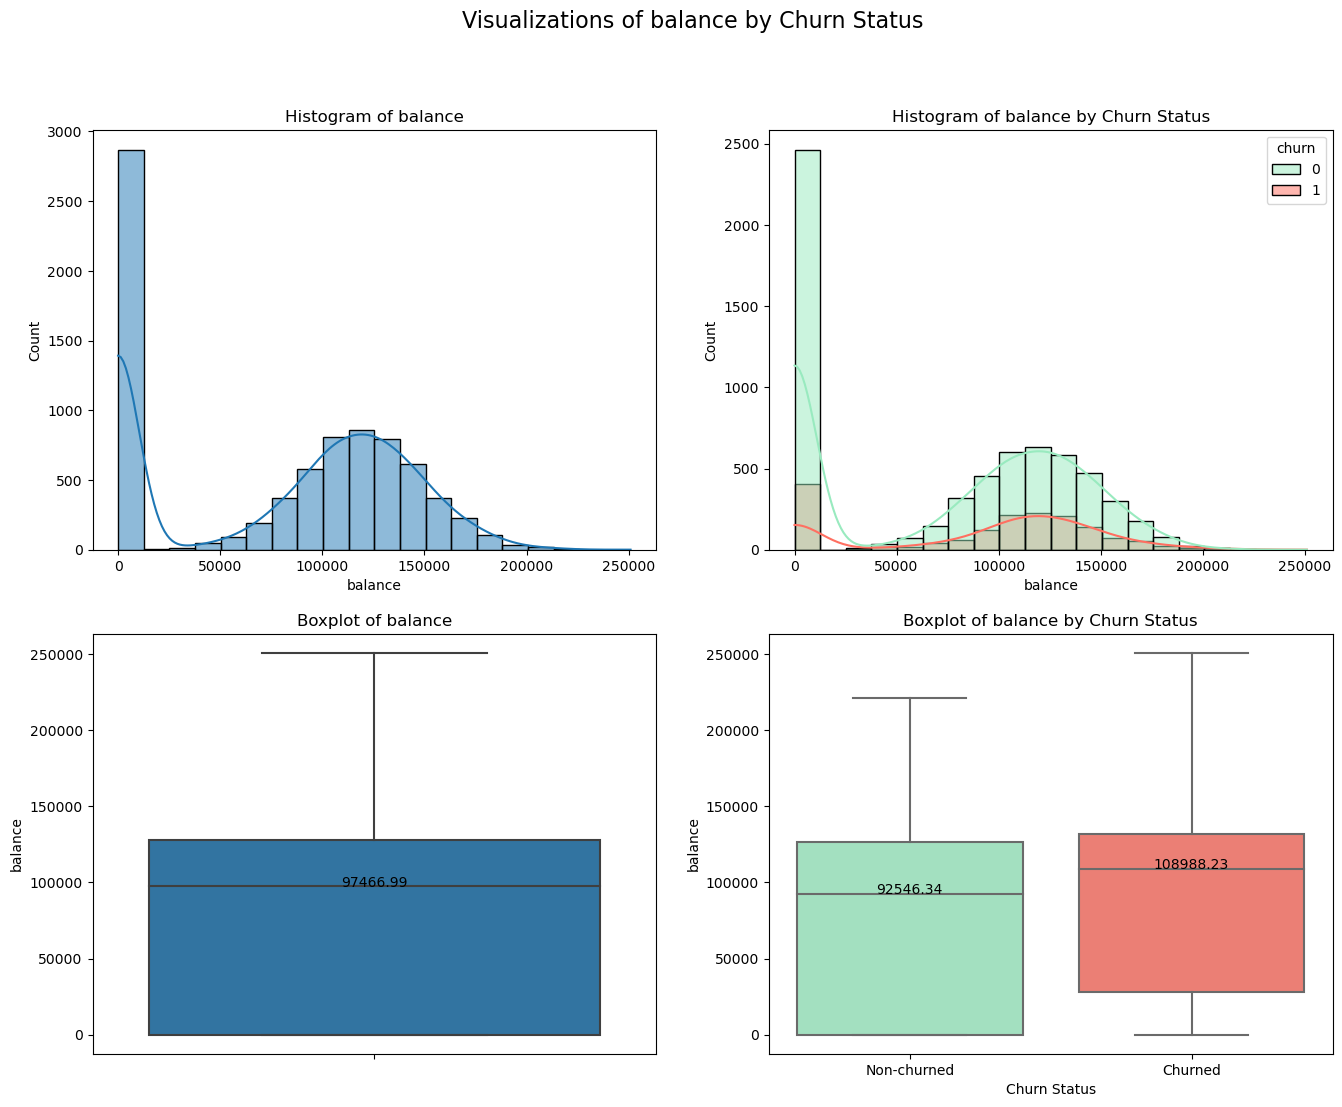

In [20]:
plot_numerical_feature('balance', data=df_train)

In [21]:
#Checking % churnwith 0 balance
filtered_data = df_train[df_train['balance'] == 0]
round(filtered_data['churn'].mean(),2)

0.14

**Conclusions:**
1. Both distributions of balance for churned and non-churned customers appear similar. However, it is worth noting that there is a significant number of customers with a balance of zero, and among them, the churn rate is slightly lower (14%) compared to the churn rate for the entire dataset (20%). Additionally, the median balance of churned customers appears to be higher, indicating that higher balances may be associated with a higher likelihood of churn.

### Number of Products

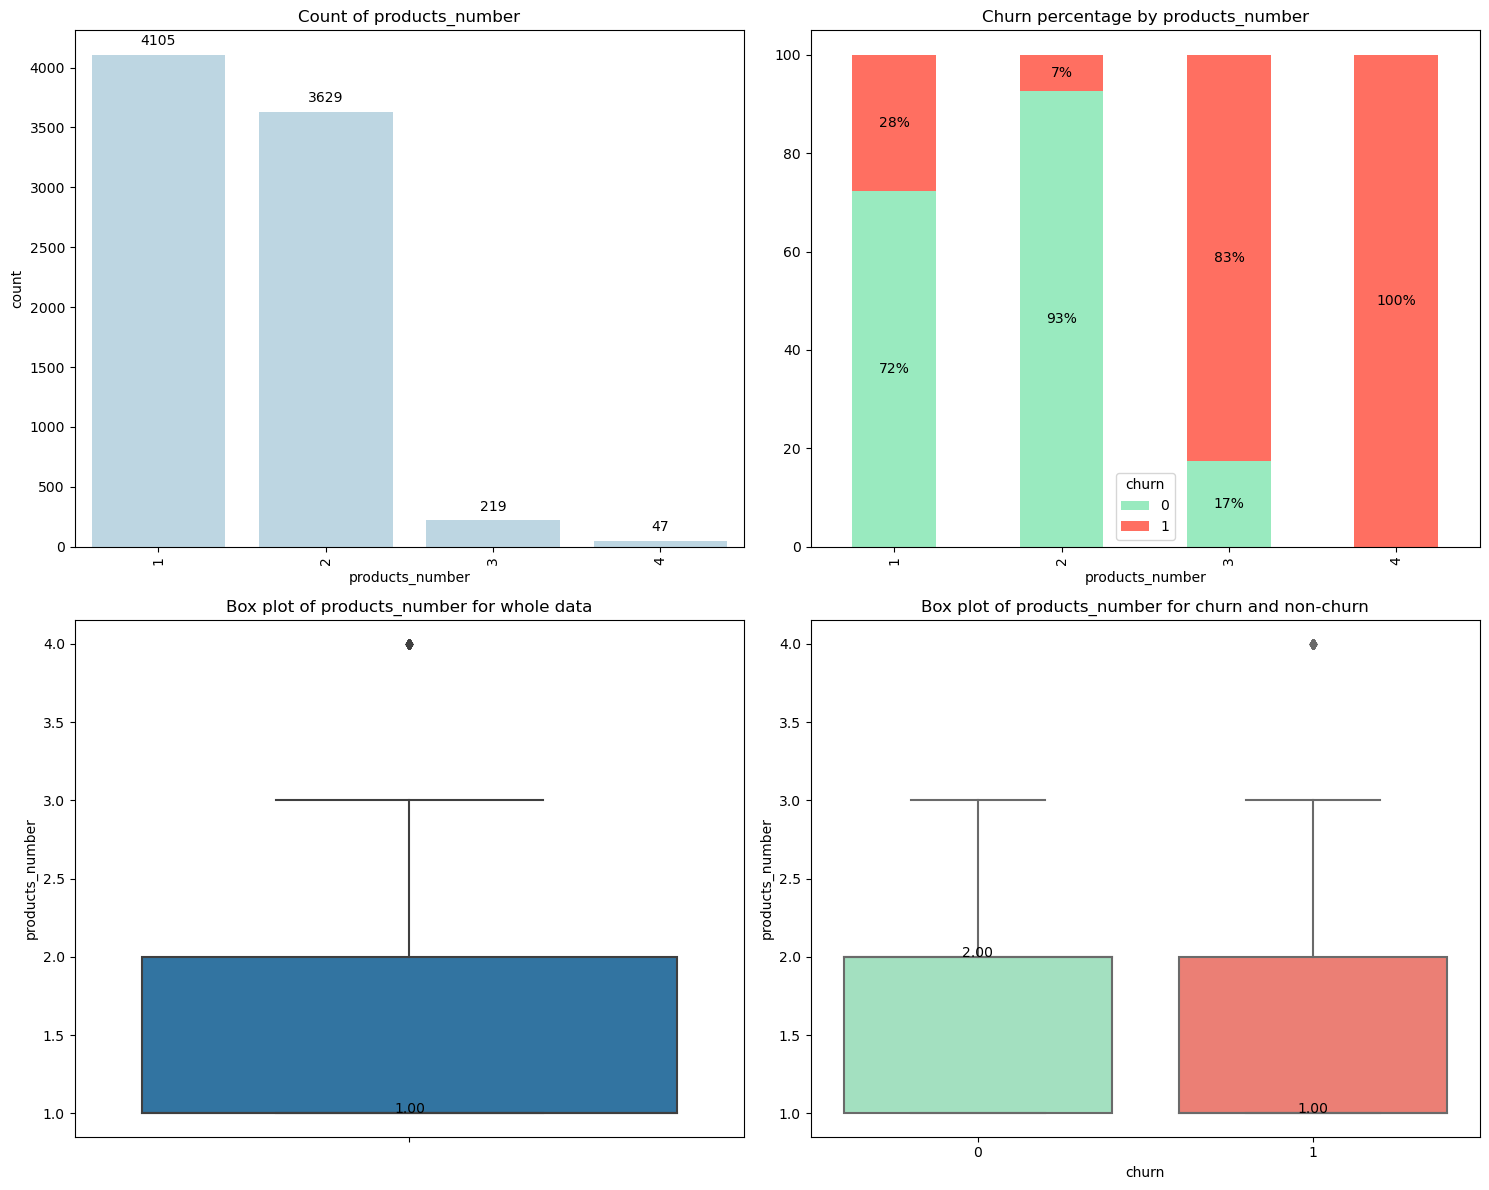

In [22]:
plot_ordinal_feature('products_number', data=df_train)

**Conclusions:**
1. The analysis of churn rates based on the number of products reveals significant differences. Customers with 3 and 4 products exhibit much higher churn rates, reaching 85% and 100% respectively. However, it's worth noting that these customer groups are considerably smaller compared to the first two groups. Interestingly, the group with 2 products displays the lowest churn rate of only 7%.

### Credit Card

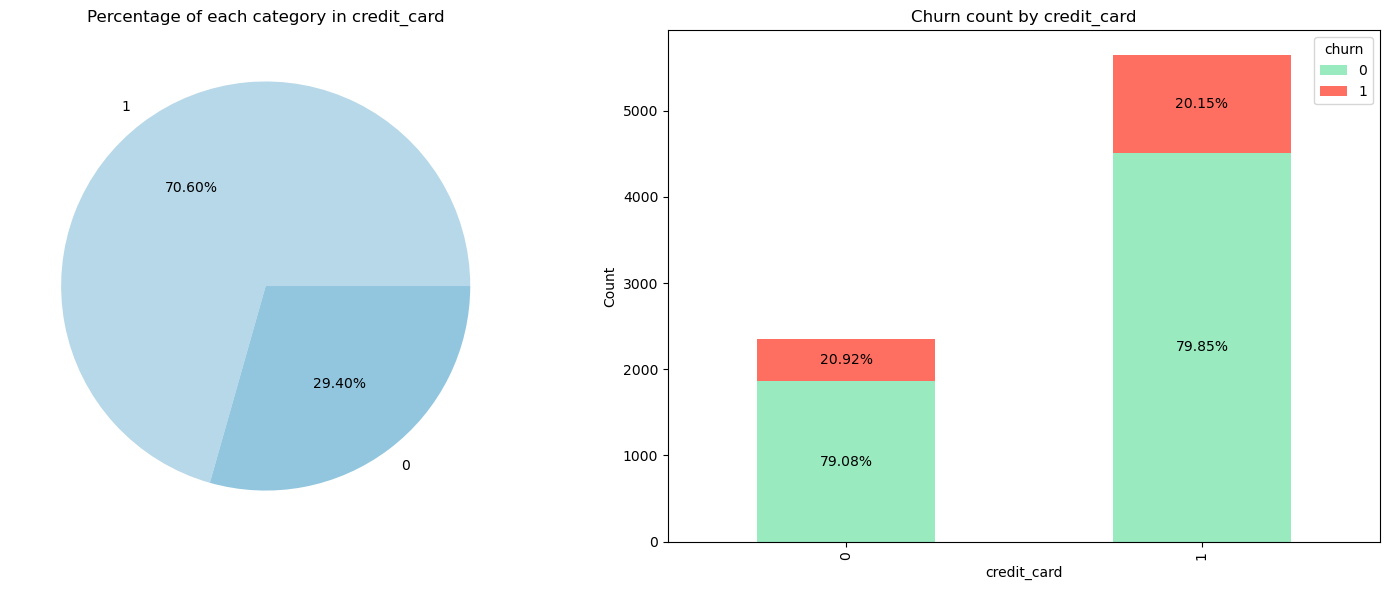

In [23]:
plot_categorical_feature('credit_card', data=df_train)

**Conclusions:**
1. Approximately 70% of customers in the dataset have a credit card.
2. However, there is no noticeable difference in the churn rate between customers with a credit card and those without.

### Active Member

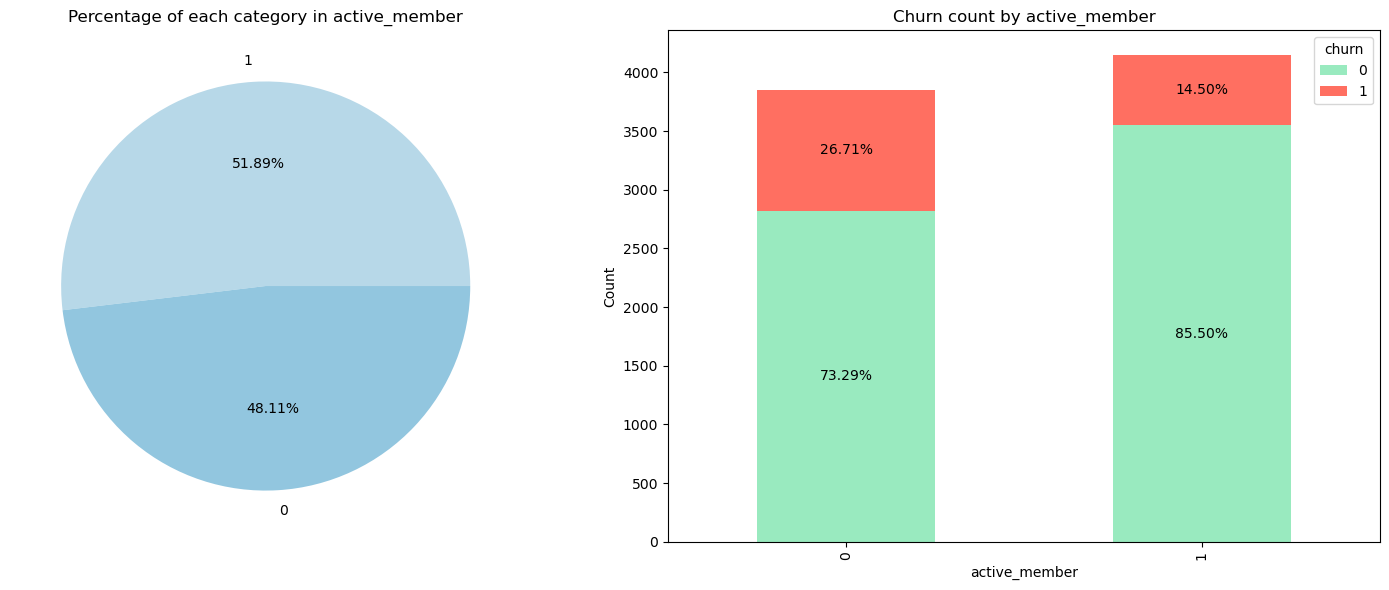

In [24]:
plot_categorical_feature('active_member', data=df_train)

**Conclusions:**
1. Among the customers in the dataset, approximately 52% are classified as active members of the bank.
2. There is a notable difference in the churn rate between active and inactive members. The churn rate for inactive members is 27%, which is significantly higher than the churn rate of 15% for active members.

### Estimated Salary

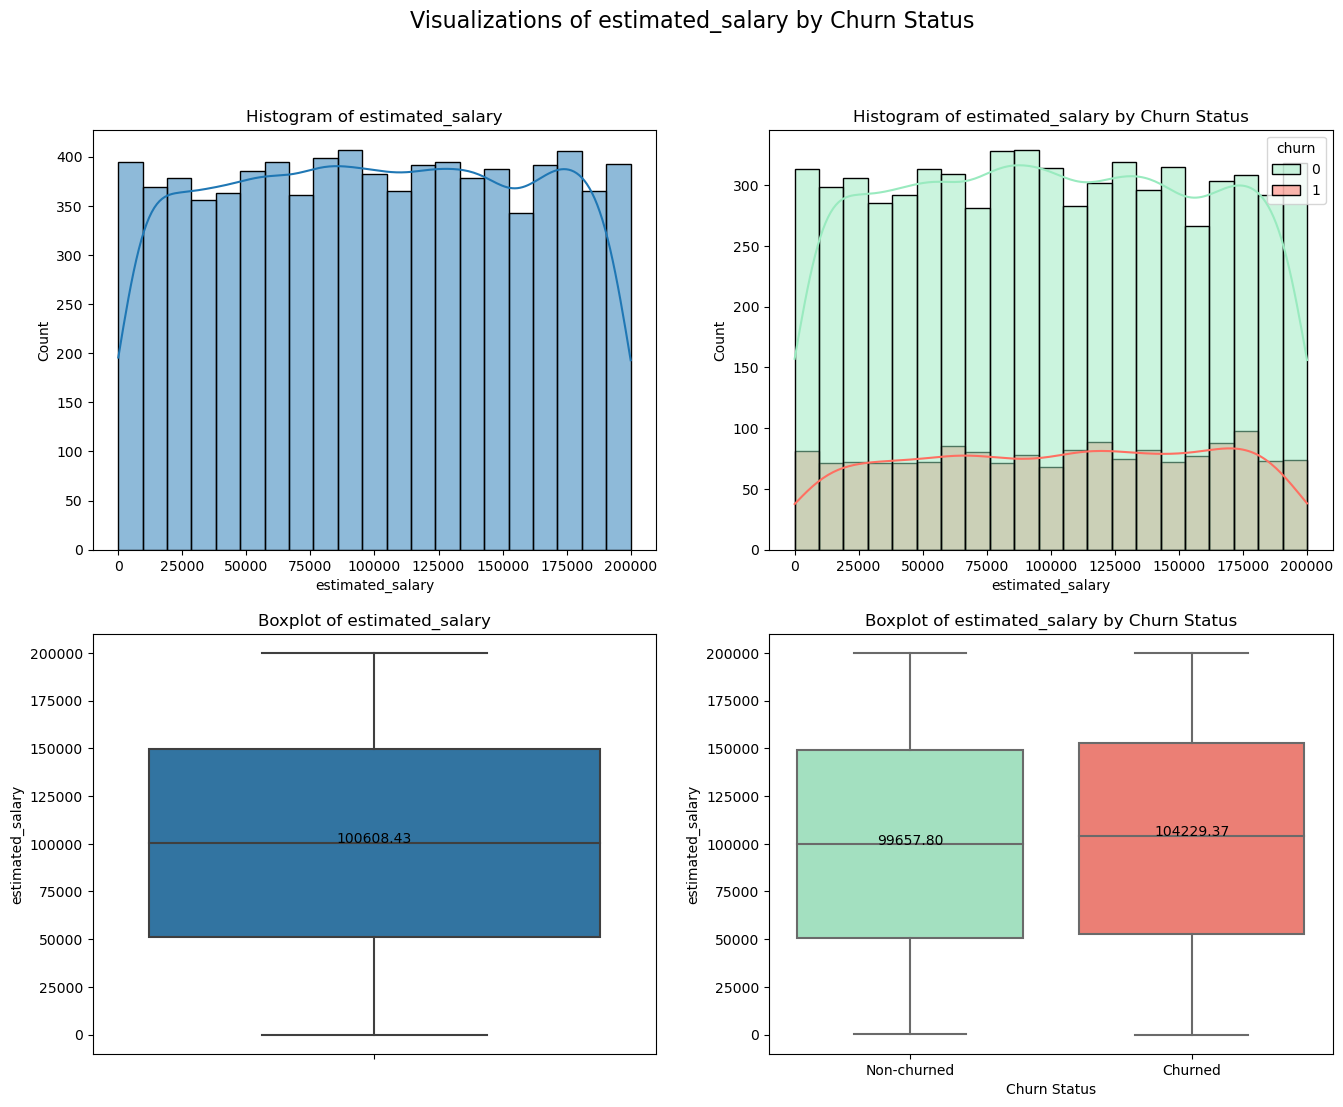

In [25]:
plot_numerical_feature('estimated_salary', data=df_train)

**Conclusions:**
1. The estimated salary does not exhibit significant differences in terms of churn rate. The median estimated salary is slightly higher in the churned group, but the overall distribution does not show a strong relationship with churn.
2. Surprisingly, the distribution of estimated salary appears to be univariate, contrary to the expectation of a positively skewed distribution with a long right tail. However, without access to the data provider to verify the integrity of the dataset, it cannot be investigate further.

## Modeling

In this project, a systematic approach is employed for conducting Machine Learning experiments. A pipeline-based structure is utilized, incorporating preprocessing steps and classifier application. The function **run_experiments** is used for executing each experiment, taking in a preprocessor, a set of classifiers, a pipeline, and an experiment name. This function integrates the preprocessor and classifiers into the pipeline, ensuring consistency and efficiency in data preprocessing and model fitting. Model hyperparameters are optimized using either GridSearchCV or RandomizedSearchCV, depending on the classifier type in function **run_experiments_hyperparameter**.

To ensure that the models do not overfit or underperform on unseen data, a **train/test split methodology** is used. The data is split into two subsets: training and testing sets. The training set is used for the initial model training and the validation  of different method applied. This setup provides a robust way to check the model's performance and make necessary adjustments. The test set is exclusively reserved for the final model evaluation, providing an unbiased assessment of the model's performance on new, unseen data.

The function returns a dictionary containing the best performing models for each classifier, along with a DataFrame summarizing the performance metrics of each classifier. This allows comparison and assessment of different models.

In the pipeline, all numerical features will be scaled using the StandardScaler transformer. This scaling process ensures that the numerical features are on a similar scale, allowing for more effective modeling and analysis.

For categorical data, the OneHotEncoder transformer will be used to perform one-hot encoding.

In [26]:
scaler = StandardScaler()
OHE_encoder = OneHotEncoder(handle_unknown='ignore', drop='first')

In [27]:
OHE_columns = ['gender','country']
columns_to_scale = ['credit_score', 'age', 'tenure', 'balance', 'products_number', 
                    'credit_card', 'active_member', 'estimated_salary']

In [28]:
X_train = df_train.drop('churn', axis=1)
y_train = df_train['churn']

In [29]:
X_test = df_test.drop('churn', axis=1)
y_test = df_test['churn']

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', scaler, columns_to_scale),
        ('OHE', OHE_encoder, OHE_columns)])

In [31]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [32]:
classifiers_base = [LogisticRegression(random_state=0),
                    RandomForestClassifier(random_state=0),
                    DecisionTreeClassifier(random_state=0),
                    XGBClassifier(random_state=0),
                    LGBMClassifier(random_state=0)]

In [33]:
classifiers_hp = [
    
    (LogisticRegression(solver='liblinear'), {
        'clf__C': (0.001, 0.01, 0.1, 1),
        'clf__penalty': ['l1', 'l2']
    }),
    
    (RandomForestClassifier(), {
        'clf__n_estimators': [50, 100, 200, 300],
        'clf__max_depth': [3, 4, 5, 7, 9],
        'clf__min_samples_split': [8, 10, 12, 15, 20, 30],
        'clf__min_samples_leaf': [4, 7, 10, 15, 30],
        'clf__bootstrap': [True, False],
        'clf__criterion': ['gini', 'entropy']
    }),
    
    (DecisionTreeClassifier(), {
        'clf__max_depth': [ 5, 6, 7, 8, 9, 10],
        'clf__min_samples_split': [2, 4, 6, 8, 10, 12],
        'clf__min_samples_leaf': [2, 3, 4, 5, 8, 10, 12],
        'clf__criterion': ['gini', 'entropy']
    }),

    (XGBClassifier(), {
        'clf__n_estimators': ss.randint(100, 500),
        'clf__learning_rate': ss.uniform(0.01, 0.1),
        'clf__max_depth': ss.randint(3, 10),  
        'clf__min_child_weight': ss.randint(25, 50),
        'clf__gamma': ss.uniform(0.3, 0.7),  
        'clf__subsample': ss.uniform(0.6, 0.4),
        'clf__colsample_bytree': ss.uniform(0.2, 0.3),  
        'clf__reg_lambda': ss.uniform(1, 2),
        'clf__reg_alpha': ss.uniform(1, 2)
    }),
    
    (LGBMClassifier(), {
        'clf__n_estimators': ss.randint(100, 500),
        'clf__learning_rate': ss.uniform(0.01, 0.1),
        'clf__max_depth': ss.randint(3, 10),
        'clf__num_leaves': ss.randint(5, 20),
        'clf__min_child_samples': ss.randint(25, 50),
        'clf__reg_lambda': ss.uniform(1, 2),  
        'clf__reg_alpha': ss.uniform(1, 2)  
    })

]

### **Experiment 1** *Base Classifiers*

In [34]:
results_df_1 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline, 
                               experiment_name='base', 
                               X=X_train, 
                               y=y_train)

In [35]:
results_df_1

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,LogisticRegression,base,0.313552,0.213497,0.594258,0.767394
1,RandomForestClassifier,base,0.582611,0.469939,0.767272,0.857793
2,DecisionTreeClassifier,base,0.503101,0.515951,0.491881,0.689608
3,XGBClassifier,base,0.571435,0.490798,0.684720,0.847424
4,LGBMClassifier,base,0.597929,0.506748,0.730240,0.862510


Conclusion:</br>
The Logistic Regression model had the lowest F1 of 0.31, indicating a weaker performance in identifying customers who churn. The other models — RandomForest, DecisionTree, XGBoost, and LightGBM — had notably better F1 scores, between 0.50 and 0.60.

The LGBMClassifier model topped the F1 scores at 0.60. This classifier also achieved the highest cross-validated ROC AUC score (0.86), which is a strong indication of its performance across a variety of threshold settings

###  Feature Engineering Experiments


####  Age Binning

In [36]:
class AgeToGeneration(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.bins = [0, 26, 42, 58, 77, 98]
        self.labels = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers', 'Silent Generation']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy['generation'] = pd.cut(X_copy['age'], self.bins, labels=self.labels, right=False, include_lowest=True)
        X_copy = X_copy.drop('age', axis=1)  
        return X_copy

    def get_feature_names(self):
        return self.transform(X).columns.tolist()

In [37]:
columns_to_scale_age_bins = ['credit_score', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member']

OHE_columns_age_bins = ['gender','country', 'generation']

preprocessor_age_bins = ColumnTransformer(transformers=[('scaler', scaler, columns_to_scale_age_bins),
                                                        ('OHE', OHE_encoder, OHE_columns_age_bins)])


pipeline_age_bins = Pipeline(steps=[('age_to_generation', AgeToGeneration()),
                                    ('preprocessor', preprocessor_age_bins)])




results_df_2 = run_experiments (preprocessor=preprocessor_age_bins, 
                                classifiers=classifiers_base, 
                                pipeline=pipeline_age_bins,
                                experiment_name='age_bins',
                                X=X_train, y=y_train);

In [38]:
results_df_2

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,LogisticRegression,age_bins,0.399587,0.292638,0.631013,0.779701
1,RandomForestClassifier,age_bins,0.561485,0.471779,0.693525,0.836554
2,DecisionTreeClassifier,age_bins,0.476666,0.484663,0.469122,0.672237
3,XGBClassifier,age_bins,0.561707,0.475460,0.687176,0.839445
4,LGBMClassifier,age_bins,0.570697,0.475460,0.715368,0.851447


In [39]:
result_df = append_dataframe(results_df_2, results_df_1)

In [40]:
result_df

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,XGBClassifier,base,0.571435,0.490798,0.684720,0.847424
1,XGBClassifier,age_bins,0.561707,0.475460,0.687176,0.839445
2,RandomForestClassifier,base,0.582611,0.469939,0.767272,0.857793
3,RandomForestClassifier,age_bins,0.561485,0.471779,0.693525,0.836554
4,LogisticRegression,age_bins,0.399587,0.292638,0.631013,0.779701
5,LogisticRegression,base,0.313552,0.213497,0.594258,0.767394
6,LGBMClassifier,base,0.597929,0.506748,0.730240,0.862510
7,LGBMClassifier,age_bins,0.570697,0.475460,0.715368,0.851447
8,DecisionTreeClassifier,base,0.503101,0.515951,0.491881,0.689608
9,DecisionTreeClassifier,age_bins,0.476666,0.484663,0.469122,0.672237


Conclusion:
<br>The introduction of age bins led to varied results across different models. For Logistic Regression, it resulted in a improvement in F1 from 0.31 to 0.40. However, other models like RandomForest, DecisionTree, XGBoost, and LightGBM experienced a slight drop in recall when using age bins.


#### Credit Score given Age

In [41]:
class CreditScoreToAge(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X['credit_score_to_age'] = X['credit_score'] / X['age']
        self.feature_names_ = X.columns.tolist()
        return X

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_

In [42]:
columns_to_scale_cs_age = ['credit_score', 'tenure', 'balance', 'products_number', 
                           'age', 'credit_score_to_age', 'credit_card', 'active_member']


OHE_columns_cs_age = ['gender','country']



preprocessor_cs_age = ColumnTransformer(
    transformers=[('scaler', scaler, columns_to_scale_cs_age),
                  ('OHE', OHE_encoder, OHE_columns_cs_age)])


pipeline_cs_age = Pipeline(steps=[('credit_to_age', CreditScoreToAge()),
                                  ('preprocessor', preprocessor_cs_age)])



results_df_3 = run_experiments(preprocessor=preprocessor_cs_age, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline_cs_age,
                               experiment_name='cs_age',
                               X=X_train, y=y_train);

In [43]:
result_df = append_dataframe(results_df_3, result_df)

In [44]:
result_df

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,XGBClassifier,cs_age,0.576831,0.494479,0.693544,0.844049
1,XGBClassifier,base,0.571435,0.490798,0.684720,0.847424
2,XGBClassifier,age_bins,0.561707,0.475460,0.687176,0.839445
3,RandomForestClassifier,base,0.582611,0.469939,0.767272,0.857793
4,RandomForestClassifier,cs_age,0.570331,0.463804,0.741003,0.853027
5,RandomForestClassifier,age_bins,0.561485,0.471779,0.693525,0.836554
6,LogisticRegression,age_bins,0.399587,0.292638,0.631013,0.779701
7,LogisticRegression,cs_age,0.334981,0.228221,0.631949,0.772372
8,LogisticRegression,base,0.313552,0.213497,0.594258,0.767394
9,LGBMClassifier,cs_age,0.599953,0.505521,0.739162,0.861117


Conclusion:<br>The inclusion of the "CustomerScore - Age interaction" (cs_age) feature produced varied effects across the models. For Logistic Regression, there was a minor improvement in F1 from the base model (0.31 to 0.33) but it was still significantly lower than the age bins experiment (0.40). For DecisionTreeClassifier, XGBClassifier and LGBMClassifier a slight increase in the F1 score from  was observed with the cs_age feature. 

Meanwhile, RandomForestClassifier saw a slight decrease in F1 scores with the cs_age feature compared to the base models, implying a minor detriment to their performance.

In terms of precision, models with the cs_age feature generally performed similarly to their base model counterparts, suggesting no significant impact from the cs_age feature on the model's ability to accurately predict positive instances.

The cs_age feature had minimal effect on the ROC AUC scores across all models, indicating that the models' ability to differentiate between classes remained fairly stable.


Overall it seems that cs_age feature mostly add some value for LogisticRegression model.

### Balancing Class Experiment

#### Random Over Sampler

In [45]:
ros = RandomOverSampler()

In [46]:
pipeline_ros = Pipeline(steps=[('preprocessor', preprocessor),
                               ('ros', ros)])


results_df_4 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline_ros,
                               experiment_name='ros',
                               X=X_train, y=y_train);

#### Random Under Sampler

In [47]:
rus = RandomUnderSampler()

In [48]:

pipeline_rus = Pipeline(steps=[('preprocessor', preprocessor),
                               ('rus', rus)])


results_df_5 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline_rus,
                               experiment_name='rus',
                               X=X_train, y=y_train);

#### SMOTE

In [49]:
sm = SMOTE()

In [50]:
pipeline_smote = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('smote', sm)])


results_df_6 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline_smote,
                               experiment_name='smote',
                               X=X_train, y=y_train);

#### Tomek Links

In [51]:
tomek = TomekLinks()

In [52]:
pipeline_tomekl = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('tomek', tomek)])




results_df_7 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline,
                               experiment_name='tomekl',
                               X=X_train, y=y_train);

In [53]:
df_balanced = append_dataframes_list([results_df_1, results_df_4, results_df_5, results_df_6, results_df_7])

In [54]:
df_balanced

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,XGBClassifier,smote,0.597163,0.552147,0.673594,0.853891
1,XGBClassifier,ros,0.591778,0.610429,0.586831,0.842025
2,XGBClassifier,rus,0.572550,0.746626,0.462508,0.845367
3,XGBClassifier,base,0.571435,0.490798,0.684720,0.847424
4,XGBClassifier,tomekl,0.571435,0.490798,0.684720,0.847424
5,RandomForestClassifier,ros,0.616568,0.541718,0.683100,0.855715
6,RandomForestClassifier,smote,0.607088,0.571779,0.644899,0.855181
7,RandomForestClassifier,rus,0.590337,0.758896,0.497667,0.858586
8,RandomForestClassifier,base,0.582611,0.469939,0.767272,0.857793
9,RandomForestClassifier,tomekl,0.582611,0.469939,0.767272,0.857793


Conclusion:<br>
Among the various imbalance class methods tested, the SMOTE (smote) method consistently showed the best results and improvement across different classifiers. Only XGBClassifier noted slightly better result utilizing RandomOverSampler. Notably, the LogisticRegression classifier exhibited the most significant positive impact, with a substantial increase in performance metrics when using imbalced method compared to the base results. This suggests that the SMOTE technique effectively addressed the class imbalance issue and improved the classifier's ability to predict the minority class. 

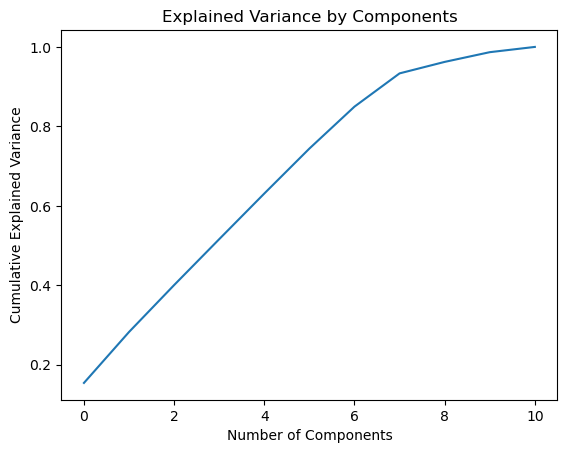

In [55]:

# Plot the explained variance ratio for each component
X_preprocessed = pipeline.fit_transform(X_train)
pca = PCA().fit(X_preprocessed)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance') 
plt.title('Explained Variance by Components')
plt.show()

It seems that 7
componets should be checked in data

In [56]:
pca = PCA(n_components=7)

In [57]:
pipeline_pca = Pipeline(steps=[('preprocessor', preprocessor),
                               ('pca', pca)])




results_df_8 = run_experiments(preprocessor=preprocessor, 
                               classifiers=classifiers_base, 
                               pipeline=pipeline_pca,
                               experiment_name='pca',
                               X=X_train, y=y_train);

In [58]:
result_pca = append_dataframe(results_df_8, results_df_1)

In [59]:
result_pca

,Classifier,Experiment,Cross-Validation F1,Cross-Validation Recall,Cross-Validation Precision,Cross-Validation ROC AUC
0,XGBClassifier,base,0.571435,0.490798,0.684720,0.847424
1,XGBClassifier,pca,0.471730,0.375460,0.634831,0.799126
2,RandomForestClassifier,base,0.582611,0.469939,0.767272,0.857793
3,RandomForestClassifier,pca,0.463754,0.341718,0.725414,0.808461
4,LogisticRegression,base,0.313552,0.213497,0.594258,0.767394
5,LogisticRegression,pca,0.259948,0.166258,0.601718,0.743634
6,LGBMClassifier,base,0.597929,0.506748,0.730240,0.862510
7,LGBMClassifier,pca,0.491341,0.379755,0.697042,0.815280
8,DecisionTreeClassifier,base,0.503101,0.515951,0.491881,0.689608
9,DecisionTreeClassifier,pca,0.440211,0.450307,0.431337,0.649094


Conclusion:
<br>In this experiment, applying Principal Component Analysis (PCA) to the dataset resulted in a drop in F1 across all classifiers. This is clear when comparing 'base' classifiers and their PCA counterparts.

The decrease in F1 suggests that PCA may not be a suitable preprocessing step for this specific task when the primary target is optimizing F1. 

### Model Optimization and Pipeline Combination

In this phase of the project, the insights and methodologies acquired from previous experiments are integrated with an extensive hyperparameter optimization process for the classifiers. The objective is to create an ensemble of machine learning models that have been fine-tuned to their optimal settings, thereby enhancing their predictive performance and utility.

Based on the results, the LogisticRegression model exhibited the highest F1 score when incorporating the age bins and the credit-to-age ratio as additional features. This suggests that these features have a positive impact on the model's ability to predict customer churn. Additionally, applying the SMOTE technique further improved the performance of the model.

Considering the upcoming experiments, the following approaches will be explored:

    Experiment 1: The baseline preprocessor will be used along with the addition of the CreditScore to Age feature. Furthermore, the Age to Generation binning will be applied, as it has shown promising results in the previous experiments for LogisticRegression. SMOTE, which has consistently yielded favorable outcomes, will also be implemented.

    Experiment 2: The baseline preprocessor will be utilized, and both the CreditScore to Age feature and SMOTE will be included. While the impact of the CreditScore feature was not as substantial, it is worth investigating whether hyperparameter optimization can enhance its contribution. SMOTE, which demonstrated notable performance across various models in previous experiments, will be applied.

    Experiment 3: This experiment will solely utilize the baseline preprocessor and employ SMOTE.

In [61]:
columns_to_scale_exp_1 = ['credit_score', 'tenure', 'balance', 'products_number', 'credit_score_to_age', 'estimated_salary',
                          'credit_card', 'active_member']

OHE_columns_exp_1 = ['gender','country', 'generation']

preprocessor_exp_1 = ColumnTransformer(transformers=[('scaler', scaler, columns_to_scale_exp_1),
                                                     ('OHE', OHE_encoder, OHE_columns_exp_1)])



pipeline_exp_1 = Pipeline(steps=[('credit_to_age', CreditScoreToAge()),
                                 ('age_to_generation', AgeToGeneration()),
                                 ('preprocessor', preprocessor_exp_1),
                                 ('smote', sm)])




best_calssifiers_1, results_df_exp_1 = run_experiments_hyperparameter (preprocessor=preprocessor_exp_1, 
                                                                       classifiers=classifiers_hp, 
                                                                       pipeline=pipeline_exp_1,
                                                                       experiment_name='experiment_1',
                                                                       rs_n_iter=150, 
                                                                       X_train=X_train, 
                                                                       y_train=y_train);

In [62]:
results_df_exp_1

,Experiment,Classifier,Train F1,Train Recall,Train Precision,Train ROC AUC
0,experiment_1,LogisticRegression,0.518554,0.715951,0.40665,0.724223
1,experiment_1,RandomForestClassifier,0.614295,0.648466,0.584071,0.765049
2,experiment_1,DecisionTreeClassifier,0.588839,0.650307,0.540449,0.753254
3,experiment_1,XGBClassifier,0.633179,0.611043,0.657671,0.764705
4,experiment_1,LGBMClassifier,0.628819,0.588957,0.675528,0.758136
5,experiment_1,Mean,0.596737,0.642945,0.572874,0.753074


In [63]:
columns_to_scale_exp_2 = ['credit_score', 'balance', 'products_number', 'tenure', 'estimated_salary',
                          'credit_score_to_age', 'age', 'credit_card', 'active_member']

OHE_columns_exp_2 = ['gender','country']

preprocessor_exp_2 = ColumnTransformer(transformers=[('scaler', scaler, columns_to_scale_exp_2),
                                                     ('OHE', OHE_encoder, OHE_columns_exp_2)])



pipeline_exp_2 = Pipeline(steps=[('credit_to_age', CreditScoreToAge()),
                                 ('preprocessor', preprocessor_exp_2),
                                 ('smote', sm)])

best_calssifiers_2, results_df_exp_2 = run_experiments_hyperparameter (preprocessor=preprocessor_exp_2, 
                                                                       classifiers=classifiers_hp, 
                                                                       pipeline=pipeline_exp_2,
                                                                       experiment_name='experiment_2',
                                                                       rs_n_iter=150, 
                                                                       X_train=X_train, 
                                                                       y_train=y_train);

In [64]:
results_df_exp_2

,Experiment,Classifier,Train F1,Train Recall,Train Precision,Train ROC AUC
0,experiment_2,LogisticRegression,0.49823,0.711656,0.383346,0.70936
1,experiment_2,RandomForestClassifier,0.62648,0.663804,0.593432,0.77366
2,experiment_2,DecisionTreeClassifier,0.603903,0.668098,0.552134,0.764504
3,experiment_2,XGBClassifier,0.6372,0.605521,0.672562,0.765006
4,experiment_2,LGBMClassifier,0.636166,0.617178,0.657299,0.767223
5,experiment_2,Mean,0.600396,0.653252,0.571755,0.755951


In [66]:
columns_to_scale_exp_3 = ['credit_score', 'balance', 'products_number', 'tenure', 'estimated_salary',
                          'age', 'credit_card', 'active_member']

OHE_columns_exp_3 = ['gender','country']

preprocessor_exp_3 = ColumnTransformer(transformers=[('scaler', scaler, columns_to_scale_exp_3),
                                                     ('OHE', OHE_encoder, OHE_columns_exp_3)])



pipeline_exp_3 = Pipeline(steps=[('preprocessor', preprocessor_exp_3),
                                 ('smote', sm)])

best_calssifiers_3, results_df_exp_3 = run_experiments_hyperparameter (preprocessor=preprocessor_exp_3, 
                                                                       classifiers=classifiers_hp, 
                                                                       pipeline=pipeline_exp_3,
                                                                       experiment_name='experiment_3', 
                                                                       rs_n_iter=150, 
                                                                       X_train=X_train, 
                                                                       y_train=y_train);

In [67]:
results_df_exp_3

,Experiment,Classifier,Train F1,Train Recall,Train Precision,Train ROC AUC
0,experiment_3,LogisticRegression,0.501865,0.692025,0.393785,0.709749
1,experiment_3,RandomForestClassifier,0.626269,0.657669,0.598145,0.772241
2,experiment_3,DecisionTreeClassifier,0.601154,0.666871,0.548471,0.762792
3,experiment_3,XGBClassifier,0.634114,0.646012,0.623024,0.772928
4,experiment_3,LGBMClassifier,0.634803,0.619018,0.65171,0.767123
5,experiment_3,Mean,0.599641,0.656319,0.563027,0.756966


In [70]:
results_df_exp_full = concatenated_df = pd.concat([results_df_exp_1, results_df_exp_2, results_df_exp_3], 
                                                  ignore_index=True).sort_values(by=['Classifier', 'Train F1'],
                                                  ascending=False).reset_index(drop=True)


In [71]:
results_df_exp_full

,Experiment,Classifier,Train F1,Train Recall,Train Precision,Train ROC AUC
0,experiment_2,XGBClassifier,0.6372,0.605521,0.672562,0.765006
1,experiment_3,XGBClassifier,0.634114,0.646012,0.623024,0.772928
2,experiment_1,XGBClassifier,0.633179,0.611043,0.657671,0.764705
3,experiment_2,RandomForestClassifier,0.62648,0.663804,0.593432,0.77366
4,experiment_3,RandomForestClassifier,0.626269,0.657669,0.598145,0.772241
5,experiment_1,RandomForestClassifier,0.614295,0.648466,0.584071,0.765049
6,experiment_2,Mean,0.600396,0.653252,0.571755,0.755951
7,experiment_3,Mean,0.599641,0.656319,0.563027,0.756966
8,experiment_1,Mean,0.596737,0.642945,0.572874,0.753074
9,experiment_1,LogisticRegression,0.518554,0.715951,0.40665,0.724223


Coclusion:

Comparing three experiment the differences of mean F1 are very minor however the highest value can be observed in experiment_2.  Since our main goal was the highet F1 metric we use models from experiment_2 to evaluate our models.

## Final evaluation

In [82]:
evaluation_df = evaluate_best_classifiers(best_calssifiers_2, X_test=X_test, y_test=y_test)

In [83]:
final_df = pd.merge(results_df_exp_2, evaluation_df, on='Classifier' )

In [84]:
final_df

,Experiment,Classifier,Train F1,Train Recall,Train Precision,Train ROC AUC,Test F1,Test Recall,Test Precision,Test ROC AUC
0,experiment_2,LogisticRegression,0.49823,0.711656,0.383346,0.70936,0.492487,0.724816,0.372946,0.771286
1,experiment_2,RandomForestClassifier,0.62648,0.663804,0.593432,0.77366,0.591385,0.624079,0.561947,0.849594
2,experiment_2,DecisionTreeClassifier,0.603903,0.668098,0.552134,0.764504,0.587336,0.660934,0.528487,0.838617
3,experiment_2,XGBClassifier,0.6372,0.605521,0.672562,0.765006,0.590909,0.542998,0.648094,0.849816
4,experiment_2,LGBMClassifier,0.636166,0.617178,0.657299,0.767223,0.604410,0.572482,0.640110,0.855442


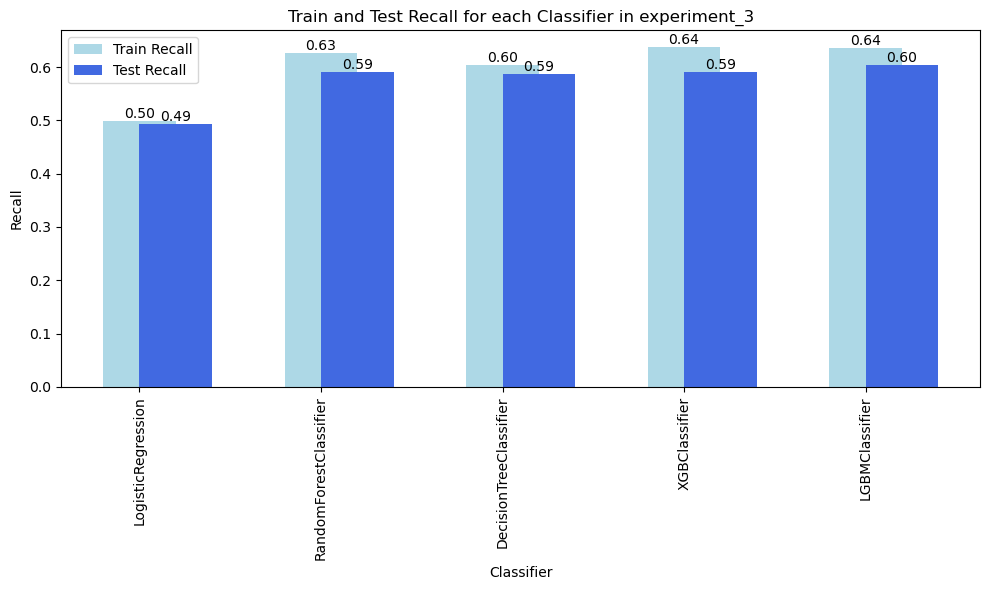

In [86]:
#showing results of each classfier on grpah for train and test


classifiers = final_df['Classifier'].unique()
train_recalls = final_df['Train F1']
test_recalls = final_df['Test F1']

x = range(len(classifiers))


plt.figure(figsize=(10, 6))

bar1 = plt.bar(x, train_recalls, width=0.4, label='Train Recall', color='#add8e6', align='center')
bar2 = plt.bar(x, test_recalls, width=0.4, label='Test Recall', color='#4169e1', align='edge')

plt.xlabel('Classifier')
plt.ylabel('Recall')
plt.title('Train and Test Recall for each Classifier in experiment_3')
plt.xticks(x, classifiers, rotation='vertical')

# Adding numbers on top of the bars
for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.legend()
plt.tight_layout()
plt.show()

LGBMClassifier: This model delivers the best performance overall, with the highest F1 scores for both training and testing data. Its precision is high on both datasets, showing its strength in correctly predicting positive cases out of all predicted positives. Although its recall drops slightly in the testing data compared to the training data, it still outperforms all the other models in terms of F1 score on the test set, making it the most balanced model in terms of precision and recall.

XGBClassifier: This model also performs well, presenting the second-best F1 score on the testing dataset. It shows strength in precision on both datasets, indicating good performance in accurately predicting churned customers. However, its recall rate is somewhat lower, especially on the testing dataset, which impacts its overall F1 score.

RandomForestClassifier and DecisionTreeClassifier: Both these models show similar performance in terms of F1 score on the testing dataset. However, the RandomForestClassifier slightly outperforms the DecisionTreeClassifier on the training dataset. Their precision and recall are well-balanced on the training data, but they decrease on the testing data, impacting their overall F1 score.

LogisticRegression: This model has the lowest F1 score on both datasets. It performs very well in terms of recall, but its precision is significantly lower, which heavily impacts its F1 score. This suggests that the model identifies a high number of true positives but also misclassifies many negative instances as positive.

In summary, considering the F1 score as the main performance metric, the LGBMClassifier would be the recommended model.


## Bibliography

https://www.kaggle.com/code/omeryasirkucuk/calculation-accuracy-score-w-bank-churn-dataset
https://www.investopedia.com/terms/c/churnrate.asp
